> For more details on surrogate gradient learning, please see: 
> Neftci, E.O., Mostafa, H., and Zenke, F. (2019). Surrogate Gradient Learning in Spiking Neural Networks.
> https://arxiv.org/abs/1901.09948

# Tutorial 3: Training a spiking neural network on a simple vision dataset

Friedemann Zenke (https://fzenke.net)

In Tutorial 2, we have seen how to train a simple multi-layer spiking neural network on the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). However, the spiking activity in the hidden layer was not particularly plausible in a biological sense. Here we modify the network from this previous tutorial by adding activity regularizer, which encourages solutions with sparse spiking.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision

In [2]:
# The coarse network structure is dicated by the Fashion MNIST dataset. 
nb_inputs  = 28*28
nb_hidden  = 100
nb_outputs = 10

time_step = 1e-2
nb_steps  = 100

batch_size = 256

In [3]:
dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")

In [4]:
# Here we load the Dataset
root = os.path.expanduser("~/data/datasets/torch/mnist")
train_dataset = torchvision.datasets.MNIST(root, train=True, transform=None, target_transform=None, download=True)
test_dataset = torchvision.datasets.MNIST(root, train=False, transform=None, target_transform=None, download=True)

In [5]:
# Standardize data
# x_train = torch.tensor(train_dataset.train_data, device=device, dtype=dtype)
x_train = np.array(train_dataset.data, dtype=np.float)
x_train = x_train.reshape(x_train.shape[0],-1)/255
# x_test = torch.tensor(test_dataset.test_data, device=device, dtype=dtype)
x_test = np.array(test_dataset.data, dtype=np.float)
x_test = x_test.reshape(x_test.shape[0],-1)/255

# y_train = torch.tensor(train_dataset.train_labels, device=device, dtype=dtype)
# y_test  = torch.tensor(test_dataset.test_labels, device=device, dtype=dtype)
y_train = np.array(train_dataset.targets, dtype=np.int64)
y_test  = np.array(test_dataset.targets, dtype=np.int64)

C:\Users\Joshua\AppData\Local\Temp\ipykernel_11492\1224777063.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_train = np.array(train_dataset.data, dtype=np.float)
C:\Users\Joshua\AppData\Local\Temp\ipykernel_11492\1224777063.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_test = np.array(test_dataset.data, dtype=np.float)


(-0.5, 27.5, 27.5, -0.5)

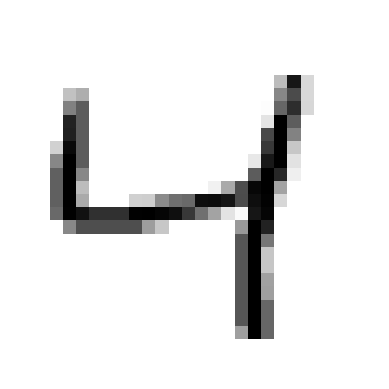

In [6]:
# Here we plot one of the raw data points as an example
data_id = 2
plt.imshow(x_train[data_id].reshape(28,28), cmap=plt.cm.gray_r)
plt.axis("off")

In [7]:
x_train.shape

(60000, 784)

Since we are working with spiking neural networks, we ideally want to use a temporal code to make use of spike timing. To that end, we will use a spike latency code to feed spikes to our network.

In [8]:
def current2firing_time(x, tau=20, thr=0.3, tmax=1.0, epsilon=1e-7):
    """ Computes first firing time latency for a current input x assuming the charge time of a current based LIF neuron.

    Args:
    x -- The "current" values

    Keyword args:
    tau -- The membrane time constant of the LIF neuron to be charged
    thr -- The firing threshold value 
    tmax -- The maximum time returned 
    epsilon -- A generic (small) epsilon > 0

    Returns:
    Time to first spike for each "current" x
    """
    idx = x<thr
    x = np.clip(x,thr+epsilon,1e9)
    T = tau*np.log(x/(x-thr))
    T[idx] = tmax
    return T

def spike_fn(x):
    out = torch.zeros_like(x)
    out[x > 0] = 1.0
    return out
        
def sparse_data_generator(X, y, batch_size, nb_steps, nb_units, shuffle=True ):
    """ This generator takes datasets in analog format and generates spiking network input as sparse tensors. 

    Args:
        X: The data ( sample x event x 2 ) the last dim holds (time,neuron) tuples
        y: The labels
    """

    labels_ = np.array(y,dtype=np.int64)
    number_of_batches = len(X)//batch_size
    sample_index = np.arange(len(X))

    # compute discrete firing times
    tau_eff = 20e-3/time_step
    firing_times = np.array(current2firing_time(X, tau=tau_eff, tmax=nb_steps), dtype=np.int64)
    unit_numbers = np.arange(nb_units)

    if shuffle:
        np.random.shuffle(sample_index)

    total_batch_count = 0
    counter = 0
    while counter<number_of_batches:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]

        coo = [ [] for i in range(3) ]
        for bc,idx in enumerate(batch_index):
            
            batch = [bc for _ in range(len(times))]
            coo[0].extend(batch)
            

        i = torch.LongTensor(coo).to(device)
        v = torch.FloatTensor(np.ones(len(coo[0]))).to(device)
    
        X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size,nb_steps,nb_units])).to(device)
        y_batch = torch.tensor(labels_[batch_index],device=device)

        yield X_batch.to(device=device), y_batch.to(device=device)

        counter += 1

In [9]:
def scale_image(image, scale, time_step):
    scaled_image = image*scale
    for i,prob in enumerate(scaled_image):
        if (prob > 1):
            new_prob = 1
            scaled_image[i] = new_prob
    rate_of_scaled_image = scaled_image/time_step
    average_rate = torch.mean(rate_of_scaled_image)
    return scaled_image, average_rate

In [10]:
def images2spike(x, y, batch_size, shuffle, **kwargs):  
    '''Converts images to spike trains'''
    labels_ = np.array(y,dtype=np.int64)
    number_of_batches = len(x)//batch_size
    sample_index = np.arange(len(x))

    if shuffle:
        np.random.shuffle(sample_index)

    total_batch_count = 0
    counter = 0

    batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
    while counter < number_of_batches:
        x_batch = torch.empty((len(x[batch_index]), nb_steps, nb_inputs)).to(device)
        for i, image in enumerate(x[batch_index]):
            tensor_image = torch.Tensor(image) # probabilities tensor
            zero_image = torch.zeros(tensor_image.shape)
            spike_train = torch.empty((nb_steps, nb_inputs))
            for t in range(nb_steps):
                spike_t = torch.bernoulli(tensor_image)
                spike_train[t] = spike_t
            x_batch[i] = spike_train
        y_batch = torch.tensor(labels_[batch_index],device=device) 

        yield x_batch,  y_batch

        counter += 1

### Setup of the spiking network model

In [11]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

In [12]:
weight_scale = 0.01

w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale)

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale)

print("init done")

init done


In [13]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

## Training the network

In [14]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

In [15]:
def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    for t in range(nb_steps):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn +h1[:,t]
        new_mem = (beta*mem +syn)*(1.0-rst)

        mem_rec.append(mem)
        spk_rec.append(out)
        
        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    spk_rec2 = []
    for t in range(nb_steps):
        mthr = out-1.0
        output = spike_fn(mthr)
        rst = output.detach() # We do not want to backprop through the reset

        new_flt = alpha*flt +h2[:,t]
        new_out = (beta*out +flt)*(1.0-rst)

        flt = new_flt
        out = new_out

        out_rec.append(out) # membrane potential
        spk_rec2.append(output) # spike train

    out_rec = torch.stack(out_rec,dim=1)
    spk_rec2 = torch.stack(spk_rec2, dim=1)

    return spk_rec2,  spk_rec

In [16]:
def train(x_data, y_data, scale=1, lr=1e-3, nb_epochs=10):
    params = [w1,w2]
    optimizer = torch.optim.Adamax(params, lr=lr, betas=(0.9,0.999))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()
    
    loss_hist = []
    for e in range(nb_epochs):
        local_loss = []
        for x_local, y_local in images2spike(x_data, y_data, batch_size, shuffle=True):
            output, spks = run_snn(x_local)
            spike_count =torch.sum(output,1)
            mean_firing_rate = spike_count/(nb_steps*time_step)

            log_p_y = log_softmax_fn(mean_firing_rate)
            
            # Here we set up our regularizer loss
            # The strength paramters here are merely a guess and there should be ample room for improvement by
            # tuning these paramters.
            reg_loss = 1e-7*torch.sum(spks) # L1 loss on total number of spikes
            reg_loss += 1e-8*torch.mean(torch.sum(torch.sum(spks,dim=0),dim=0)**2) # L2 loss on spikes per neuron

            # Here we combine supervised loss and the regularizer
            loss_val = loss_fn(log_p_y, y_local) 

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            local_loss.append(loss_val.item())
        mean_loss = np.mean(local_loss)
        print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
        loss_hist.append(mean_loss)
        
    return loss_hist
        
        
def compute_classification_accuracy(x_data, y_data, batch_size, shuffle, **kwargs):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    for x_local, y_local in images2spike(x_data, y_data, batch_size, shuffle=True, **kwargs):
        output, _ = run_snn(x_local)
        spike_count =torch.sum(output,1)
        mean_firing_rate = spike_count/(nb_steps*time_step)
        _, am = torch.max(mean_firing_rate, 1)
        tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
    return np.mean(accs)

In [17]:
loss_hist = train(x_train, y_train, lr=2e-4, nb_epochs=200)

Epoch 1: loss=2.14797
Epoch 2: loss=1.34097
Epoch 3: loss=0.67477
Epoch 4: loss=0.39669
Epoch 5: loss=0.34825
Epoch 6: loss=0.38511
Epoch 7: loss=0.17316
Epoch 8: loss=0.27005
Epoch 9: loss=0.34094
Epoch 10: loss=0.24919
Epoch 11: loss=0.33855
Epoch 12: loss=0.27334
Epoch 13: loss=0.33275
Epoch 14: loss=0.23456
Epoch 15: loss=0.22802
Epoch 16: loss=0.12870
Epoch 17: loss=0.32645
Epoch 18: loss=0.23443
Epoch 19: loss=0.12530
Epoch 20: loss=0.13432
Epoch 21: loss=0.21613
Epoch 22: loss=0.22903
Epoch 23: loss=0.18211
Epoch 24: loss=0.15036
Epoch 25: loss=0.17570
Epoch 26: loss=0.13659
Epoch 27: loss=0.16198
Epoch 28: loss=0.14738
Epoch 29: loss=0.14577
Epoch 30: loss=0.09248
Epoch 31: loss=0.15356
Epoch 32: loss=0.12966
Epoch 33: loss=0.15326
Epoch 34: loss=0.14209
Epoch 35: loss=0.11043
Epoch 36: loss=0.13962
Epoch 37: loss=0.16623
Epoch 38: loss=0.22655
Epoch 39: loss=0.10256
Epoch 40: loss=0.13804
Epoch 41: loss=0.09451
Epoch 42: loss=0.24090
Epoch 43: loss=0.15261
Epoch 44: loss=0.235

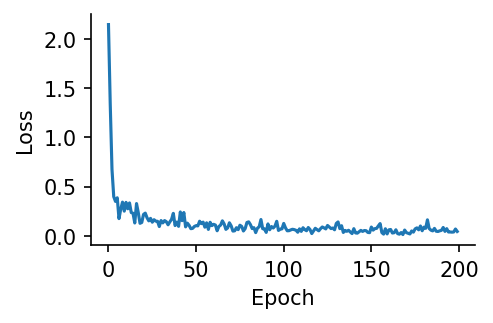

In [18]:
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

In [19]:
print("Training accuracy: %.3f"%(compute_classification_accuracy(x_train,y_train, batch_size=256, shuffle=True)))
print("Test accuracy: %.3f"%(compute_classification_accuracy(x_test,y_test, batch_size=256, shuffle=True)))

Training accuracy: 0.950
Test accuracy: 0.931
